## Data reading and Data Insights

**Keeping a Journal Participant: jarinw9b, 16 days participation**

*Dataset:* 'Keeping a journal' vs 'Not Keeping a journal' study

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_keeping_a_journal_-_jarinw9b_2025-04-15 08_51_29.090//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_keeping_a_journal_-_jarinw9b_2025-04-15 08_51_29.090//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: jarinw9b
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [3]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has 2 unique values.
Unique values are: ['ca773388-eb42-4716-995a-476ed72c0475'
 '2b274a9c-65b2-4808-97bd-e8a709792414']


#### Participation of the study

In [4]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  2b274a9c-65b2-4808-97bd-e8a709792414                  16
1  ca773388-eb42-4716-995a-476ed72c0475                   3


Besides the expected participant who met the study’s criteria and participated for 16 days, another participant was observed who neither provided the necessary consent nor completed any surveys.

#### Missing Values

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 2b274a9c-65b2-4808-97bd-e8a709792414 ---

  Outcome:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

--- Participant ca773388-eb42-4716-995a-476ed72c0475 ---

  Outcome:
    Start date:           2025-04-12
    End of expected 16d:  2025-04-27
    Expected days count:  16
    Completed days count: 3
    Missed days count:    13
    Missed dates:
       2025-04-15
       2025-04-16
       2025-04-17
       2025-04-18
       2025-04-19
       2025-04-20
       2025-04-21
       2025-04-22
       2025-04-23
       2025-04-24
       2025-04-25
       2025-04-26
       2025-04-27

  Mediators:
    Start date:           2025-04-12
    End of expected 16d:  2025-04-27
    Expected days count:  

The expected participant completed every survey during her 16-day involvement. The non-study participant took part on only three of those days.

#### Remove Participants Who Joined Outside the Study

In [6]:
df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
df_mea.shape[0]

32

#### Data Preperation

In [7]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-04-14 20:24:25.970258+00:00,Mediators,2b274a9c-65b2-4808-97bd-e8a709792414,15,Keeping a journal,NaN,NaN,NaN,NaN,6.0,7.0


In [8]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [9]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [10]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
37,2025-03-30 20:08:03.519544+00:00,Outcome,2b274a9c-65b2-4808-97bd-e8a709792414,0,Keeping a journal,6.0,8.0,9.0,1.0,NaN,NaN
35,2025-03-31 20:04:04.323725+00:00,Outcome,2b274a9c-65b2-4808-97bd-e8a709792414,1,Keeping a journal,6.0,8.0,9.0,1.0,NaN,NaN
33,2025-04-01 20:21:32.287270+00:00,Outcome,2b274a9c-65b2-4808-97bd-e8a709792414,2,Keeping a journal,6.0,8.0,9.0,1.0,NaN,NaN
31,2025-04-02 18:45:27.034499+00:00,Outcome,2b274a9c-65b2-4808-97bd-e8a709792414,3,Keeping a journal,6.0,8.0,9.0,1.0,NaN,NaN
29,2025-04-03 18:39:59.616697+00:00,Outcome,2b274a9c-65b2-4808-97bd-e8a709792414,4,Not keeping a journal,8.0,8.0,1.0,9.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)   

#### Data Shape

In [11]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 16
Columns: 11


#### Data types of columns

In [12]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [13]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 2b274a9c-65b2-4808-97bd-e8a709792414 ---

  Outcome:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-03-30
    End of expected 16d:  2025-04-14
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question4_re

#### Missing Values for Confirmations between 08.00 - 21.00

In [14]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 16 days have participation confirmations; no missing days found.


#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             16.000000                   16.000000   
mean               7.500000                    6.562500   
std                4.760952                    1.093542   
min                0.000000                    5.000000   
25%                3.750000                    6.000000   
50%                7.500000                    6.500000   
75%               11.250000                    7.250000   
max               15.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   16.000000                   16.000000   
mean                     7.687500                    4.812500   
std                      0.873212                    3.970202   
min                      6.000000                    1.000000   
25%                      7.000000                    1.000000   
50%                      8.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 37 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            16 non-null     datetime64[ns, UTC]
 1   measurement_name            16 non-null     object             
 2   participant_id              16 non-null     object             
 3   current_day_of_study        16 non-null     int64              
 4   current_intervention_name   16 non-null     object             
 5   survey1_question1_response  16 non-null     float64            
 6   survey1_question2_response  16 non-null     float64            
 7   survey1_question3_response  16 non-null     float64            
 8   survey1_question4_response  16 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

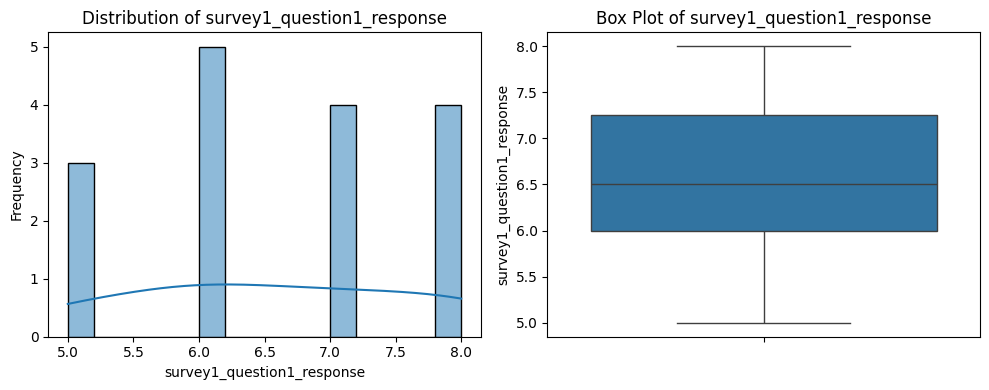

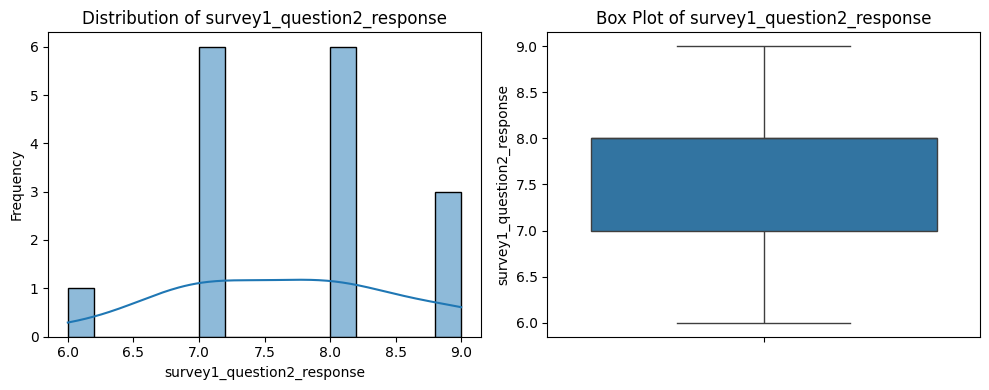

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

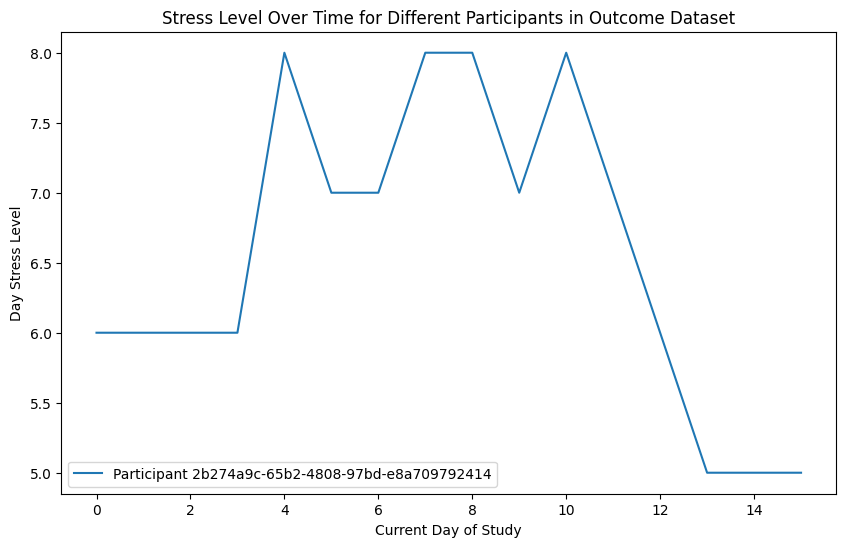

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6))  

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

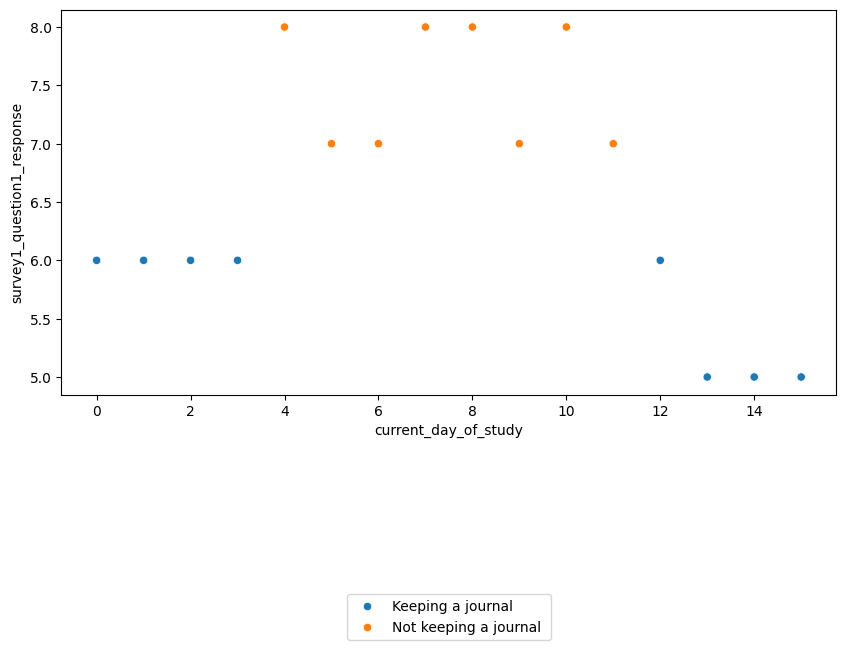

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

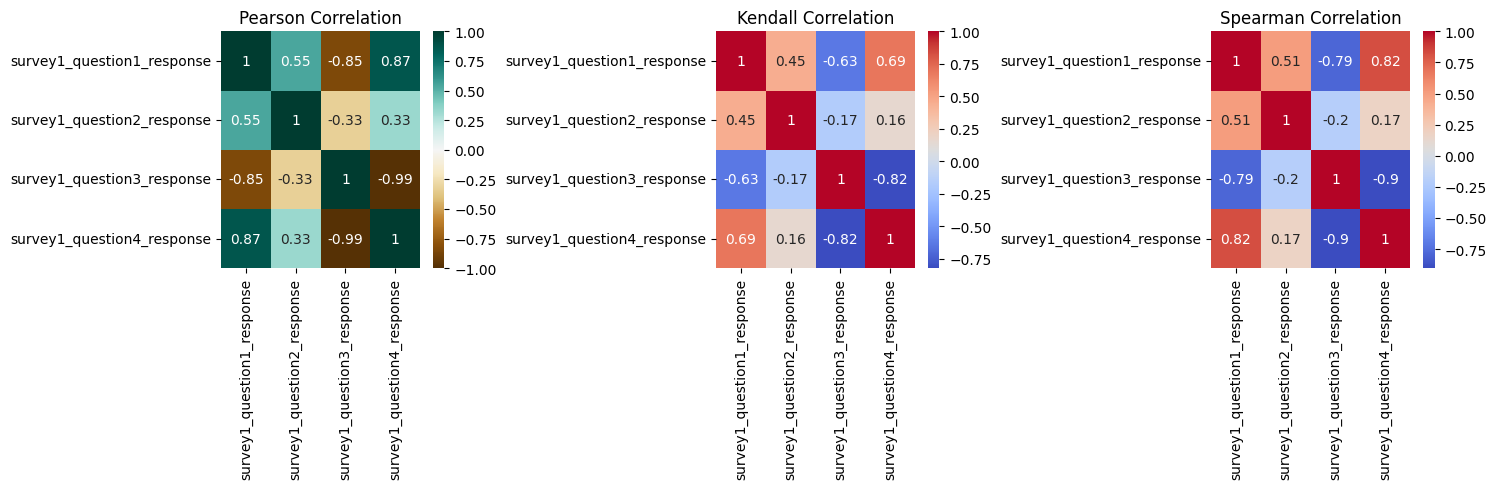

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Keeping a journal vs Not Keeping a Journal

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of Outcomes: Today Stress Level

In [21]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        'Keeping a journal ',
        'Not keeping a journal '
    ])
]

journal     = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Keeping a journal ',
    'survey1_question1_response'
]
no_journal  = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Not keeping a journal ',
    'survey1_question1_response'
]

n_journal    = journal.count()
n_no_journal = no_journal.count()
std_journal    = journal.std(ddof=1)
std_no_journal = no_journal.std(ddof=1)

print(f"Journal days:     n = {n_journal}, std = {std_journal:.2f}, mean = {journal.mean():.2f}")
print(f"No Journal days:  n = {n_no_journal}, std = {std_no_journal:.2f}, mean = {no_journal.mean():.2f}\n")

Journal days:     n = 8, std = 0.52, mean = 5.62
No Journal days:  n = 8, std = 0.53, mean = 7.50



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        'Keeping a journal ',
        'Not keeping a journal '
    ])
]

journal     = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Keeping a journal ',
    'survey1_question2_response'
]
no_journal  = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Not keeping a journal ',
    'survey1_question2_response'
]

n_journal    = journal.count()
n_no_journal = no_journal.count()
std_journal    = journal.std(ddof=1)
std_no_journal = no_journal.std(ddof=1)

print(f"Journal days:     n = {n_journal}, std = {std_journal:.2f}, mean = {journal.mean():.2f}")
print(f"No Journal days:  n = {n_no_journal}, std = {std_no_journal:.2f}, mean = {no_journal.mean():.2f}\n")

Journal days:     n = 8, std = 0.74, mean = 7.38
No Journal days:  n = 8, std = 0.93, mean = 8.00



#### Examination of Outcomes: Mean Stress-Relief Score for Journal (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much journaling alleviated participants’ stress on days they performed.

In [23]:
df_mea.survey1_question3_text[0]

'Did your miracle stress-shrinking method (journaling) help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes? <b>(Answer ONLY if you have kept a journal.)</b>'

In [24]:
# 'Did your miracle stress-shrinking method (journaling) help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes?(Answer ONLY if you have kept a journal.)
mean_q3_journaling = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Keeping a journal ',
    'survey1_question3_response'
].mean()
mean_q3_journaling.item()

8.625

**Mean Stress-Relief Score for Journaling (Q1): 8.625**
On days when the participant kept a journal, she rated Question 3 — "Did your miracle stress-shrinking method (journaling) help you feel like a calm, happy puppy or was it more like trying to train a cat to do your taxes?" — an average of 8.625 out of 10, highlighting journaling’s strong effectiveness as a stress-relief practice.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Journaling (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not write journal.

In [25]:
df_mea.survey1_question4_text[0]

'When you skipped the method (journaling) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b>(Answer ONLY when a journal is not kept!)</b>'

In [26]:
# 'When you skipped the method (journaling) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”?(Answer ONLY when a journal is not kept!)
mean_q4_no_journaling = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == 'Not keeping a journal ',
    'survey1_question4_response'
].mean()
mean_q4_no_journaling.item()

8.375

**Mean Stress-Management Difficulty Score Without Journaling (Q4): 8.375**  
On days when the participant skipped journaling, they rated Question 4—“When you skipped the method (journaling) today, did managing stress feel more like ‘breezing through a sunny park’ or ‘juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles’?”—an average of **8.375** out of 10, indicating that without journaling they found stress management considerably more difficult.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [27]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(['Keeping a journal ', 'Not keeping a journal '])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == 'Keeping a journal ').astype(int)
X = sm.add_constant(df_mea_o['D'])

# OLS Regression
ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.784
Model:                                    OLS   Adj. R-squared:                  0.769
Method:                         Least Squares   F-statistic:                     50.81
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):           5.11e-06
Time:                                11:55:57   Log-Likelihood:                -11.359
No. Observations:                          16   AIC:                             26.72
Df Residuals:                              14   BIC:                             28.26
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [28]:
# GLSAR Regression with AR(1) errors (Feasible GLS)
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.775
Model:                                  GLSAR   Adj. R-squared:                  0.758
Method:                         Least Squares   F-statistic:                     44.82
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):           1.48e-05
Time:                                11:55:57   Log-Likelihood:                -10.790
No. Observations:                          15   AIC:                             25.58
Df Residuals:                              13   BIC:                             27.00
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Keeping a Journal and Mediators

In [29]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']

    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == 'Keeping a journal ').astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of Keeping a Journal ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 102 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.531  0.406    -2.275     -0.716      0.024    0.014     314.0   
rho       0.303  0.336    -0.321      0.901      0.019    0.017     310.0   
sigma     0.604  0.134     0.389      0.873      0.007    0.007     386.0   

          ess_tail  r_hat  
beta_int     490.0   1.00  
rho          410.0   1.00  
sigma        497.0   1.01  
P(beta_int ≤ –0.5) = 98.70%
P(–0.5 < beta_int < 0) = 1.20%
P(beta_int ≥ 0) = 0.10%
P(Stress reduction of Keeping a Journal ≥ 0.5) = 98.70%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 564 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.458  0.183    -1.821     -1.094      0.008    0.007     480.0   
beta_f1   0.570  0.130     0.299      0.797      0.006    0.005     407.0   
rho      -0.315  0.296    -0.824      0.294      0.015    0.015     365.0   
sigma     0.400  0.092     0.255      0.581      0.004    0.004     468.0   

          ess_tail  r_hat  
beta_int     524.0   1.00  
beta_f1      530.0   1.01  
rho          197.0   1.00  
sigma        559.0   1.00  
P(beta_int ≤ –0.5) = 100.00%
P(–0.5 < beta_int < 0) = 0.00%
P(beta_int ≥ 0) = 0.00%
P(Stress reduction of Keeping a Journal ≥ 0.5) = 100.00%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 544 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.565  0.284    -2.195     -1.065      0.014    0.015     473.0   
beta_f2   0.379  0.174     0.031      0.691      0.009    0.008     387.0   
rho       0.017  0.396    -0.735      0.866      0.036    0.029     126.0   
sigma     0.510  0.119     0.295      0.716      0.007    0.006     312.0   

          ess_tail  r_hat  
beta_int     469.0   1.01  
beta_f2      512.0   1.00  
rho           68.0   1.01  
sigma        297.0   1.00  
P(beta_int ≤ –0.5) = 99.60%
P(–0.5 < beta_int < 0) = 0.40%
P(beta_int ≥ 0) = 0.00%
P(Stress reduction of Keeping a Journal ≥ 0.5) = 99.60%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 906 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.457  0.214    -1.872     -1.049      0.010    0.010     417.0   
beta_f1   0.453  0.183     0.088      0.796      0.009    0.008     441.0   
beta_f2   0.169  0.165    -0.143      0.501      0.009    0.006     377.0   
rho      -0.231  0.309    -0.903      0.326      0.016    0.011     378.0   
sigma     0.411  0.097     0.271      0.627      0.005    0.004     346.0   

          ess_tail  r_hat  
beta_int     539.0    1.0  
beta_f1      429.0    1.0  
beta_f2      506.0    1.0  
rho          343.0    1.0  
sigma        569.0    1.0  
P(beta_int ≤ –0.5) = 99.90%
P(–0.5 < beta_int < 0) = 0.10%
P(beta_int ≥ 0) = 0.00%
P(Stress reduction of Keeping a Journal ≥ 0.5) = 99.90%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 122 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.658  0.437    -2.411     -0.717      0.030    0.022     241.0   
rho       0.296  0.347    -0.282      0.998      0.022    0.016     243.0   
sigma     0.616  0.132     0.401      0.874      0.007    0.006     341.0   

          ess_tail  r_hat  
beta_int     291.0   1.00  
rho          198.0   1.00  
sigma        391.0   1.01  
P(beta_int ≤ –0.5) = 98.60%
P(–0.5 < beta_int < 0) = 1.10%
P(beta_int ≥ 0) = 0.30%


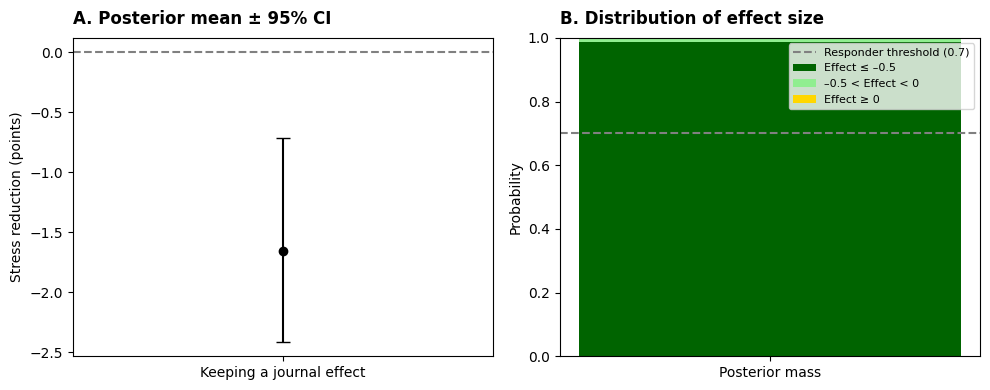

In [30]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == 'Keeping a journal ').astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.0)

with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)        

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Keeping a journal effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()